# Sidebander
The sidebander is an instrument which composes an awg (living in a parametric sequencer) and a microwave source. The sequencer is used to modulate the microwave source carrier to produce a single sideband. The instrument keeps track of the sideband information and the sequencer information and can be used directly to control the underlying instruments (with some reduced functionality).
<br><br>
First we set up a template element which can be used to sideband a microwave source. Parameters of the sidebander will be used in building this sequence. For more information on pulse building look at the examples in https://github.com/QCoDeS/lomentum/tree/master/docs
<br><br>
Then we import the instruments we are going to need which compose the sidebander (microwave source and an awg wrapped in a parametric sequencer). Choose whether to use real ones or 

In [2]:
import numpy as np
import os
import yaml
from pprint import pprint
from lomentum.loader import read_element
from lomentum.plotting import plotter
from qcodes.instrument.base import InstrumentBase
from qcodes import Instrument
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.customised_instruments.interfaces.microwave_source_interface import SimulatedMicrowaveSourceInterface, SGS100AMicrowaveSourceInterface
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import SimulatedAWGInterface, AWG5014Interface
from qdev_wrappers.customised_instruments.composite_instruments.parametric_sequencer.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.composite_instruments.sidebander.sidebander import Sidebander

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/station_configurator.py:21: UserWarning: ruamel yaml not found station configurator is falling back to pyyaml. It's highly recommended to install ruamel.yaml. This fixes issues with scientific notation and duplicate instruments in the YAML file
  warnings.warn("ruamel yaml not found station configurator is falling back to pyyaml. "


In [3]:
def print_params(*instruments):
    for instr in instruments:
        print('\n')
        print(instr.name.upper())
        for k, v in instr.parameters.items():
            if k != 'IDN':
                print(k, ': ', v())
        for k, v in instr.submodules.items():
            if isinstance(v, InstrumentBase):
                print_params(v)

In [4]:
with open('sidebanding_element.yaml') as f:
    yf = yaml.safe_load(f)
    pprint(yf)
    template_element = read_element(yf)

{'duration': 2e-05,
 'segments': {'I': [{'cosine': {'amplitude': 'I_amplitude',
                                'duration': 2e-05,
                                'frequency': 'sideband_frequency',
                                'offset': 'I_offs',
                                'phase': 0}}],
              'Q': [{'sine': {'amplitude': 'Q_amplitude',
                              'duration': 2e-05,
                              'frequency': 'sideband_frequency',
                              'offset': 'Q_offs',
                              'phase': 'phase_offset'}}]},
 'transformation': {'data': [{'I_amplitude': [['status', 'amplitude']]},
                             {'Q_amplitude': [['status', 'amplitude'],
                                              ['status', 'gain_offset']]},
                             {'I_offs': [['status', 'I_offset']]},
                             {'Q_offs': [['status', 'Q_offset']]}],
                    'type': 'bilinear_transformation'}}


In [4]:
real_instruments_present = False

In [5]:
try:
    Instrument.remove_instance(sidebander) 
    Instrument.remove_instance(ps)
    Instrument.remove_instance(awg_if)
    Instrument.remove_instance(carrier_if)
    Instrument.remove_instance(awg_instrument)
    Instrument.remove_instance(microwave_source_instrument)
except NameError:
    pass

if real_instruments_present:
    sc = StationConfigurator()
    awg_instrument = sc.load_instrument('awg')
    microwave_source_instrument = sc.load_instrument('microwave_source')
    awg_if = AWG5014Interface('awg_if', awg)
    carrier_if = SGS100AMicrowaveSourceInterface('carrier_if')
else:
    awg_if = SimulatedAWGInterface('awg_if')
    carrier_if = SimulatedMicrowaveSourceInterface('carrier_if')

ps = ParametricSequencer('prametric_sequencer', awg_if)
ps.sequence_mode('element')
sidebander = Sidebander('sidebander', ps, carrier_if)

print_params(sidebander, ps, carrier_if)

setting sequence_mode to element


SIDEBANDER
frequency :  7000000000.0
carrier_frequency :  7000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


PRAMETRIC_SEQUENCER
sequence_mode :  element
repetition_mode :  inf


PRAMETRIC_SEQUENCER_SEQUENCE_PARAMETERS


PRAMETRIC_SEQUENCER_REPEAT_PARAMETERS


CARRIER_IF
frequency :  7000000000.0
power :  -10
status :  0
pulsemod_state :  0
IQ_state :  0
dual_output_state :  0


/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:15: UserWarning: Carrier status is off
  warn('Carrier status is off')
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:18: UserWarning: Sidebander carrier IQ state is off
  warn('Sidebander carrier IQ state is off')
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:166: UserWarning: No template element uploaded to sequencer.
  warn("No template element uploaded to sequencer.")


Note that we are being warned thtat the carrier is off, has the IQ_state off and there is no template element. LEt's fix these things:

uploading
setting element to 0
running


/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=800.0, top=800.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


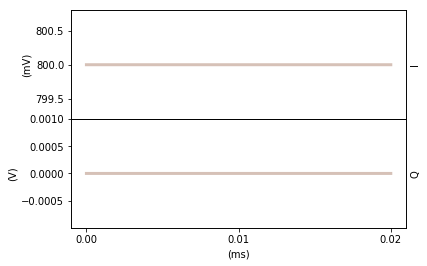

In [6]:
carrier_if.IQ_state(1)
carrier_if.status(1)
sidebander.change_sequence(template_element=template_element)

So far we haven't actually done any sidebanding but now lets change the frequency parameter. This will cause an upload to the AWG to do the sidebanding to produce the correct freqeuncy.

uploading
setting element to 0
running


SIDEBANDER
frequency :  7001000000.0
carrier_frequency :  7000000000.0
sideband_frequency :  1000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


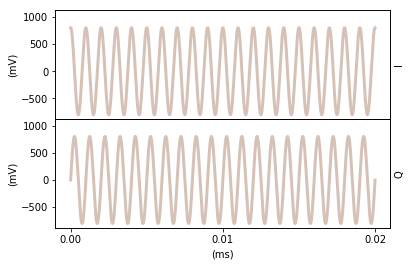

In [7]:
sidebander.frequency(7.001e9)
print_params(sidebander)

You can also change this by setting the sideband_frequency which causes a new sideband to be upladed and updates the saved frequency value.

uploading
setting element to 0
running


SIDEBANDER
frequency :  7002000000.0
carrier_frequency :  7000000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


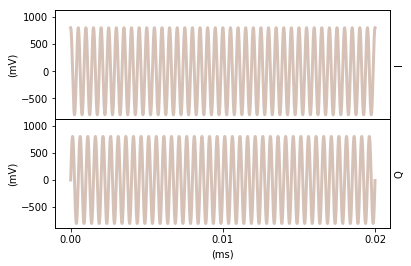

In [8]:
sidebander.sideband_frequency(2e6)
print_params(sidebander)

Changing the carrier_frequency sets the frequency on the carrier microwave source and updates the saved frequency value.

In [9]:
sidebander.carrier_frequency(5e9)
print_params(sidebander)
print_params(carrier_if)



SIDEBANDER
frequency :  5002000000.0
carrier_frequency :  5000000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


CARRIER_IF
frequency :  5000000000.0
power :  -10
status :  1
pulsemod_state :  0
IQ_state :  1
dual_output_state :  0


You may have noticed that we did a new upload for every sequencer parameter change but we could also upload a sequence and then change betweeen elements of the sequence to save time. On upload it attempts to preserve the frequency. Now changing frequency doesn't necessarily require a new upload.

uploading
setting element to 0
running
setting element to 2
running


SIDEBANDER
frequency :  5002000000.0
carrier_frequency :  5000000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


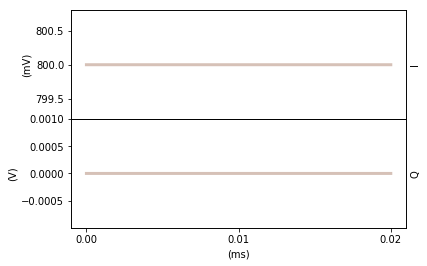

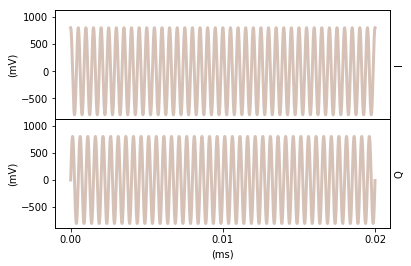

In [10]:
sidebander.change_sequence(inner_setpoints=('sideband_frequency', np.arange(10) * 1e6))
print_params(sidebander)

setting element to 8
running


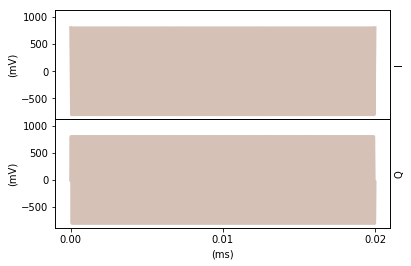

In [11]:
sidebander.sideband_frequency(8e6)

This is great to quickly traverse the setpoints uploaded but now if I try to set the parameter outside of this it won't be happy as the desired behaviour is not clear (should a new single element sequence be uploaded? should a new sequence which also includes this element be included...?). Here I try to set a frequency which would require a 88MHz sideband.

In [13]:
try:
    sidebander.sideband_frequency(20e6)
except Exception as e:
    print(e)

("('Error setting repeated element corressponding to the inner setpoints sideband_frequency: \\nValue 20000000.0 is outside of range (-500000.0, 9500000.0)', 'setting prametric_sequencer_repeat_parameters_sideband_frequency to 20000000.0'). Try changing the setpoints to include this value or set them to None and thenset this parameter", 'setting sidebander_sideband_frequency to 20000000.0')


As suggested if you change the inner setpoints to None a single element matching the suggested parameters will be uploaded. I use the single upload function of the sequencer so that only one upload is executed. Let's change a bungh of stuff while we are there:

uploading
setting element to 0
running


SIDEBANDER
frequency :  5020000000.0
carrier_frequency :  5000000000.0
sideband_frequency :  20000000.0
I_offset :  0.15
Q_offset :  0
gain_offset :  -0.3
phase_offset :  0.39269908169872414
amplitude :  0.8
status :  1


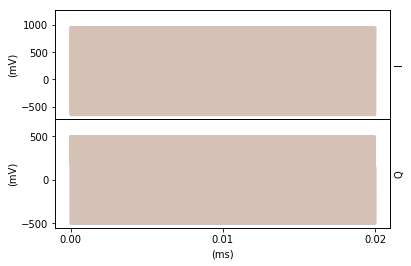

In [14]:
with sidebander.sequencer.single_upload():
    sidebander.change_sequence(inner_setpoints=None)
    sidebander.sideband_frequency(20e6)
    sidebander.I_offset(0.15)
    sidebander.gain_offset(-0.3)
    sidebander.phase_offset(np.pi / 8)
print_params(sidebander)